In [1]:
from pathlib import Path
import yaml
import numpy as np
from torch.utils.data import DataLoader

from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from hydra.utils import instantiate

import os
import torch
import sys
import pickle

sys.path.append("/home/erogullari/Workspace/cav-disentanglement")
save_dir = Path("/home/erogullari/Workspace/cav-disentanglement/results/cav_disentanglement")
out_dir = Path("/home/erogullari/Workspace/cav-disentanglement/media/explicit_disentanglement")

In [2]:
from utils.cav import compute_cavs

def get_baseline_cavs(model_name:str, layer:str, dataset_name:str, cav_type:str) -> torch.Tensor:
    base_path = Path("/home/erogullari/Workspace/cav-disentanglement/variables")
    vars_path = base_path / dataset_name / f"{model_name}" / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars['encs']
    labels = vars['labels']
    cavs, _ = compute_cavs(encs, labels, type=cav_type, normalize=True)
    return cavs

def get_orth_cavs(model_name:str, layer:str, dataset_name:str, cav_type:str, alpha:str, lr:str, opt:bool=True) -> torch.Tensor:
    base_path = Path("/home/erogullari/Workspace/cav-disentanglement/results/cav_disentanglement")
    vars_path = base_path / dataset_name / f"{model_name}_{layer}" / cav_type
    if opt:
        vars_path = vars_path / f"alpha{alpha}_lr{lr}_opt" / "cavs.pt"
    else:
        vars_path = vars_path / f"alpha{alpha}_lr{lr}" / "cavs.pt"
        
    cavs = torch.load(vars_path, map_location="cpu", weights_only=True)
    return cavs

## AUC vs Orthogonality over Epochs

In [3]:
save_dirs = {
    "celeba": save_dir / "celeba" / "vgg16_features.28",
    "elements": save_dir / "elements" / "simplenet_features.18",
    "elements_vgg16": save_dir / "elements" / "vgg16_features.28",
}

In [4]:
def visualize_auc_vs_orthogonality(exp_dir, title="", out_path=None, n_epochs=11):
    with open(exp_dir / "metrics/auc_hist.pkl", 'rb') as f:
        cav_performance_history = np.array(pickle.load(f)).mean(axis=1)[:n_epochs]
    with open(exp_dir / "metrics/uniqueness_hist.pkl", 'rb') as f:
        cav_uniqueness_history = np.array(pickle.load(f)).mean(axis=1)[:n_epochs]
    epochs_logged = list(range(0, 10 * len(cav_performance_history), 10))
    fig, ax1 = plt.subplots(figsize=(10, 6))
    palette = sns.color_palette("tab10")
    color1 = palette[0]
    color2 = palette[3]

    # Left y-axis: AUROC
    line1, = ax1.plot(
        epochs_logged,
        cav_performance_history,
        linestyle='-',
        color=color1,
        label='AUROC'
    )
    ax1.set_ylabel('AUROC', color=line1.get_color())
    ax1.set_ylim(0.49, 1.01)
    ax1.tick_params(axis='y', labelcolor=line1.get_color())

    # Right y-axis: Orthogonality
    ax2 = ax1.twinx()
    line2, = ax2.plot(
        epochs_logged,
        cav_uniqueness_history,
        linestyle='-',
        color=color2,
        label='Orthogonality'
    )
    ax2.set_ylabel('Orthogonality', color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())

    ax1.set_xlabel('Epochs')
    ax1.set_title(title)
    ax1.grid(True)

    # Combined legend
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    # ax1.legend(lines, labels, loc='best')

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', format="pdf")
        plt.close()

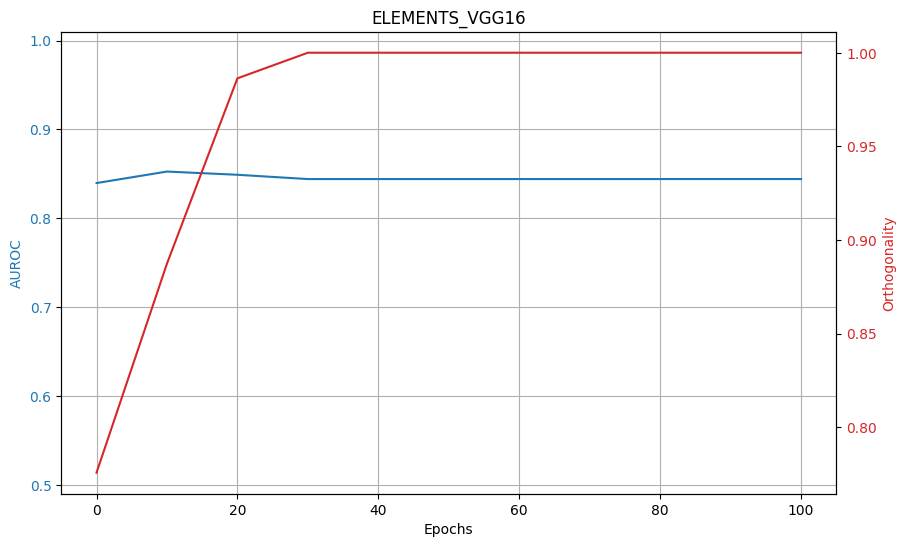

In [15]:
dataset = "elements_vgg16"
cav_type = "pattern_cav"
alpha = "10"
lr = "1e-05"

exp_dir = save_dirs[dataset] / f"{cav_type}/alpha{alpha}_lr{lr}_opt"
visualize_auc_vs_orthogonality(exp_dir, title=dataset.upper(), out_path=None)

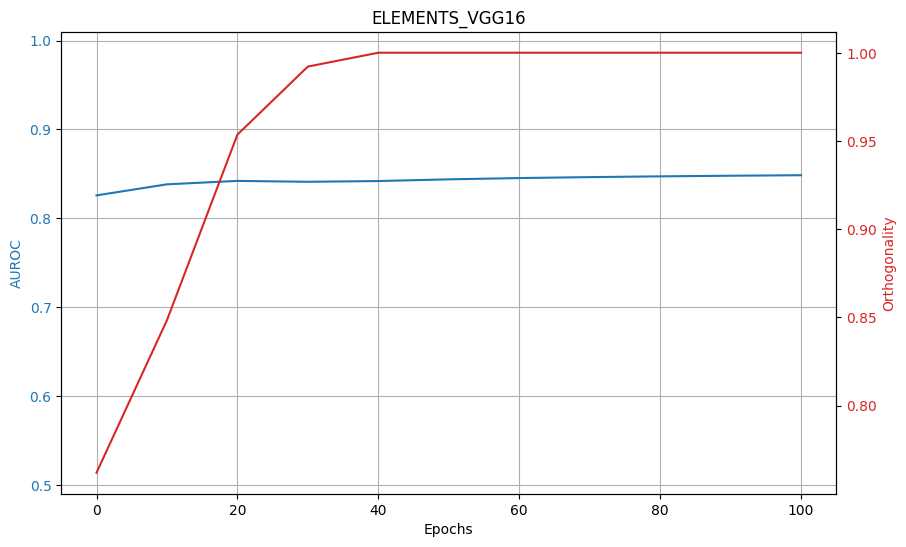

In [16]:
dataset = "elements_vgg16"
cav_type = "multi_cav"
alpha = "10"
lr = "1e-05"

exp_dir = save_dirs[dataset] / f"{cav_type}/alpha{alpha}_lr{lr}_opt"
visualize_auc_vs_orthogonality(exp_dir, title=dataset.upper(), out_path=None)

In [17]:
def visualize_auc_vs_orthogonality_double(exp_dir1, exp_dir2, title="", out_path=None, n_epochs=11, lower_lim=0.5):
    with open(exp_dir1 / "metrics/auc_hist.pkl", 'rb') as f:
        cav_performance_history1 = np.array(pickle.load(f)).mean(axis=1)[:n_epochs]
    with open(exp_dir1 / "metrics/uniqueness_hist.pkl", 'rb') as f:
        cav_uniqueness_history1 = np.array(pickle.load(f)).mean(axis=1)[:n_epochs]

    with open(exp_dir2 / "metrics/auc_hist.pkl", 'rb') as f:
        cav_performance_history2 = np.array(pickle.load(f)).mean(axis=1)[:n_epochs]
    with open(exp_dir2 / "metrics/uniqueness_hist.pkl", 'rb') as f:
        cav_uniqueness_history2 = np.array(pickle.load(f)).mean(axis=1)[:n_epochs]

    epochs_logged = list(range(0, 10 * len(cav_performance_history1), 10))
    fig, ax1 = plt.subplots(figsize=(10, 6))

    palette = sns.color_palette("tab10")
    color1 = palette[0]
    color2 = palette[3]

    # Left axis (AUROC)
    line1, = ax1.plot(epochs_logged, cav_performance_history1,
                      linestyle='-', color=color1, label='AUROC (exp1)')
    line2, = ax1.plot(epochs_logged, cav_performance_history2,
                      linestyle='--', color=color1, label='AUROC (exp2)')

    ax1.set_ylabel('AUROC', color=color1)
    ax1.set_ylim(lower_lim-0.01, 1.01)
    ax1.tick_params(axis='y', labelcolor=color1)

    # Capture limits + ticks
    # ylims = ax1.get_ylim()
    # yticks = ax1.get_yticks()

    # Right axis (Orthogonality)
    ax2 = ax1.twinx()
    line3, = ax2.plot(epochs_logged, cav_uniqueness_history1,
                      linestyle='-', color=color2, label='Orthogonality (exp1)')
    line4, = ax2.plot(epochs_logged, cav_uniqueness_history2,
                      linestyle='--', color=color2, label='Orthogonality (exp2)')

    ax2.set_ylabel('Orthogonality', color=color2)
    ax2.set_ylim(lower_lim-0.01, 1.01)
    # ax2.set_yticks(yticks)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax1.set_xlabel('Epochs')
    ax1.set_title(title)

    # Grid only once (from ax1)
    ax1.grid(True)

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', format="pdf")

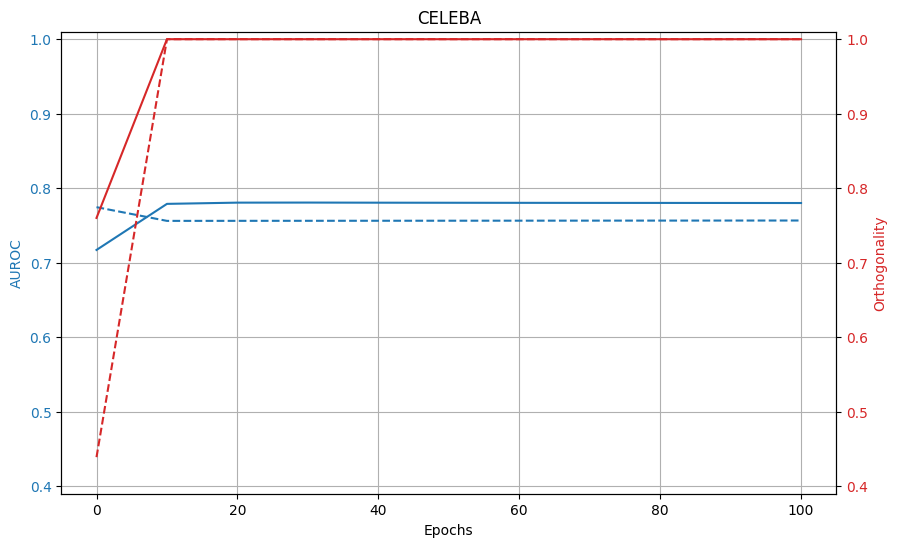

In [18]:
dataset = "celeba"
cav_type1 = "multi_cav"
cav_type2 = "pattern_cav"
alpha1 = "10"
alpha2 = "10"  
lr1 = "1e-05"
lr2 = "1e-05"

exp_dir1 = save_dirs[dataset] / f"{cav_type1}/alpha{alpha1}_lr{lr1}_opt"
exp_dir2 = save_dirs[dataset] / f"{cav_type2}/alpha{alpha2}_lr{lr2}_opt"
out_path = out_dir / f"{dataset}_auc_orthogonality.pdf"
visualize_auc_vs_orthogonality_double(exp_dir1, exp_dir2, title=dataset.upper(), out_path=out_path, lower_lim=0.4)

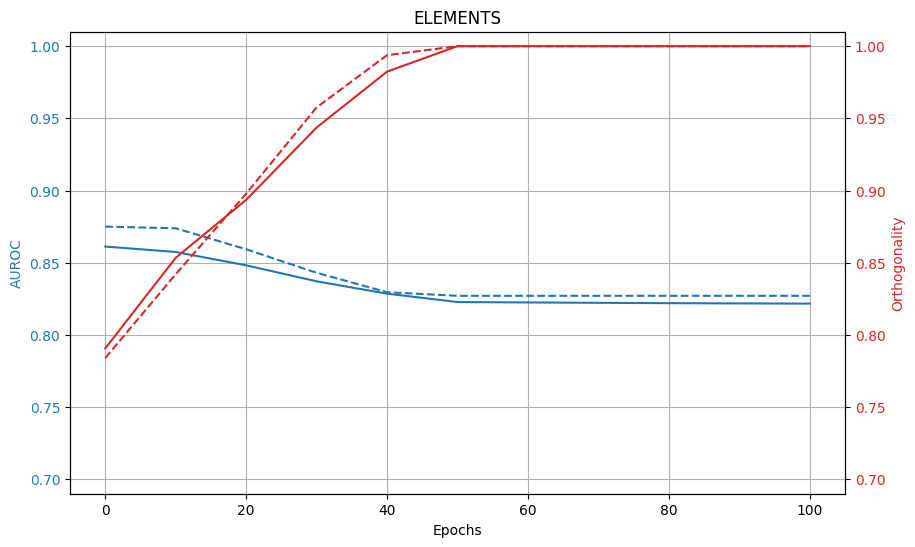

In [19]:
dataset = "elements"
cav_type1 = "multi_cav"
cav_type2 = "pattern_cav"
alpha1 = "100"
alpha2 = "10"  
lr1 = "1e-05"
lr2 = "1e-05"

exp_dir1 = save_dirs[dataset] / f"{cav_type1}/alpha{alpha1}_lr{lr1}_opt"
exp_dir2 = save_dirs[dataset] / f"{cav_type2}/alpha{alpha2}_lr{lr2}_opt"
out_path = out_dir / f"{dataset}_auc_orthogonality.pdf"
visualize_auc_vs_orthogonality_double(exp_dir1, exp_dir2, title=dataset.upper(), out_path=out_path, lower_lim=0.7)

## Cosine Sim Matrices

In [3]:
dataset = "celeba"
model = "vgg16"
layer = "features.28"
alpha1 = "10"
alpha2 = "10"
lr1 = "1e-05"
lr2 = "1e-05"

pattern_cavs_baseline = get_baseline_cavs(model, layer, dataset, "pattern_cav")
multi_cavs_baseline = get_baseline_cavs(model, layer, dataset, "multi_cav")
pattern_cavs_orth = get_orth_cavs(model, layer, dataset, "pattern_cav", alpha1, lr1)
multi_cavs_orth = get_orth_cavs(model, layer, dataset, "multi_cav", alpha2, lr2)

# print(torch.linalg.norm(pattern_cavs_baseline, dim=1), torch.linalg.norm(multi_cavs_baseline, dim=1))
# print(torch.linalg.norm(pattern_cavs_orth, dim=1), torch.linalg.norm(multi_cavs_orth, dim=1))

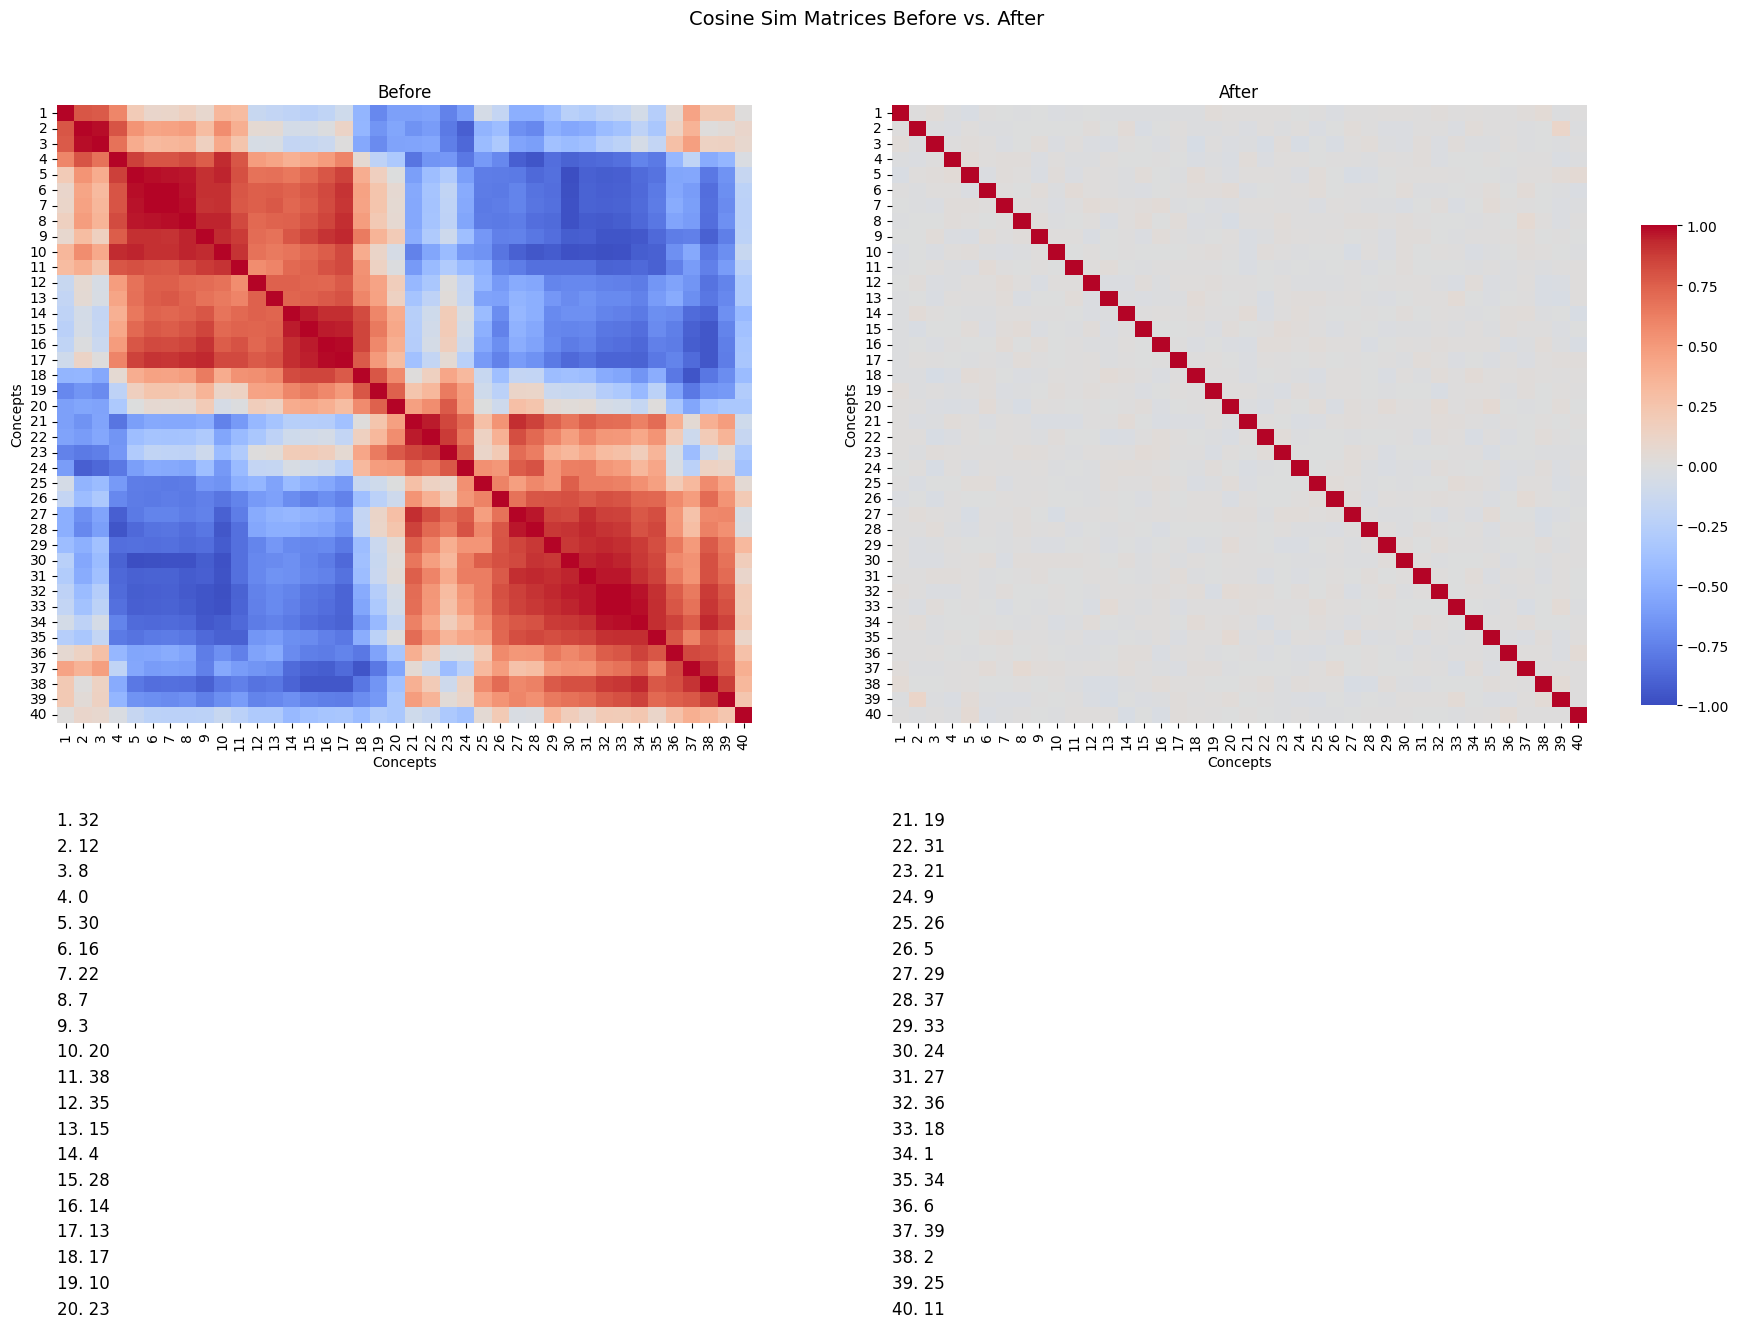

In [7]:
from utils.visualizations import visualize_before_after_sim_matrices

cos_sim_before = pattern_cavs_baseline @ pattern_cavs_baseline.T
cos_sim_after = pattern_cavs_orth @ pattern_cavs_orth.T
cnames = [str(i) for i in range(40)]

fig = visualize_before_after_sim_matrices(cos_sim_before, cos_sim_after, labels=cnames)
fig.savefig(out_dir / "celeba_cav_sim_matrices.pdf", dpi=300, bbox_inches='tight', format='pdf')
fig

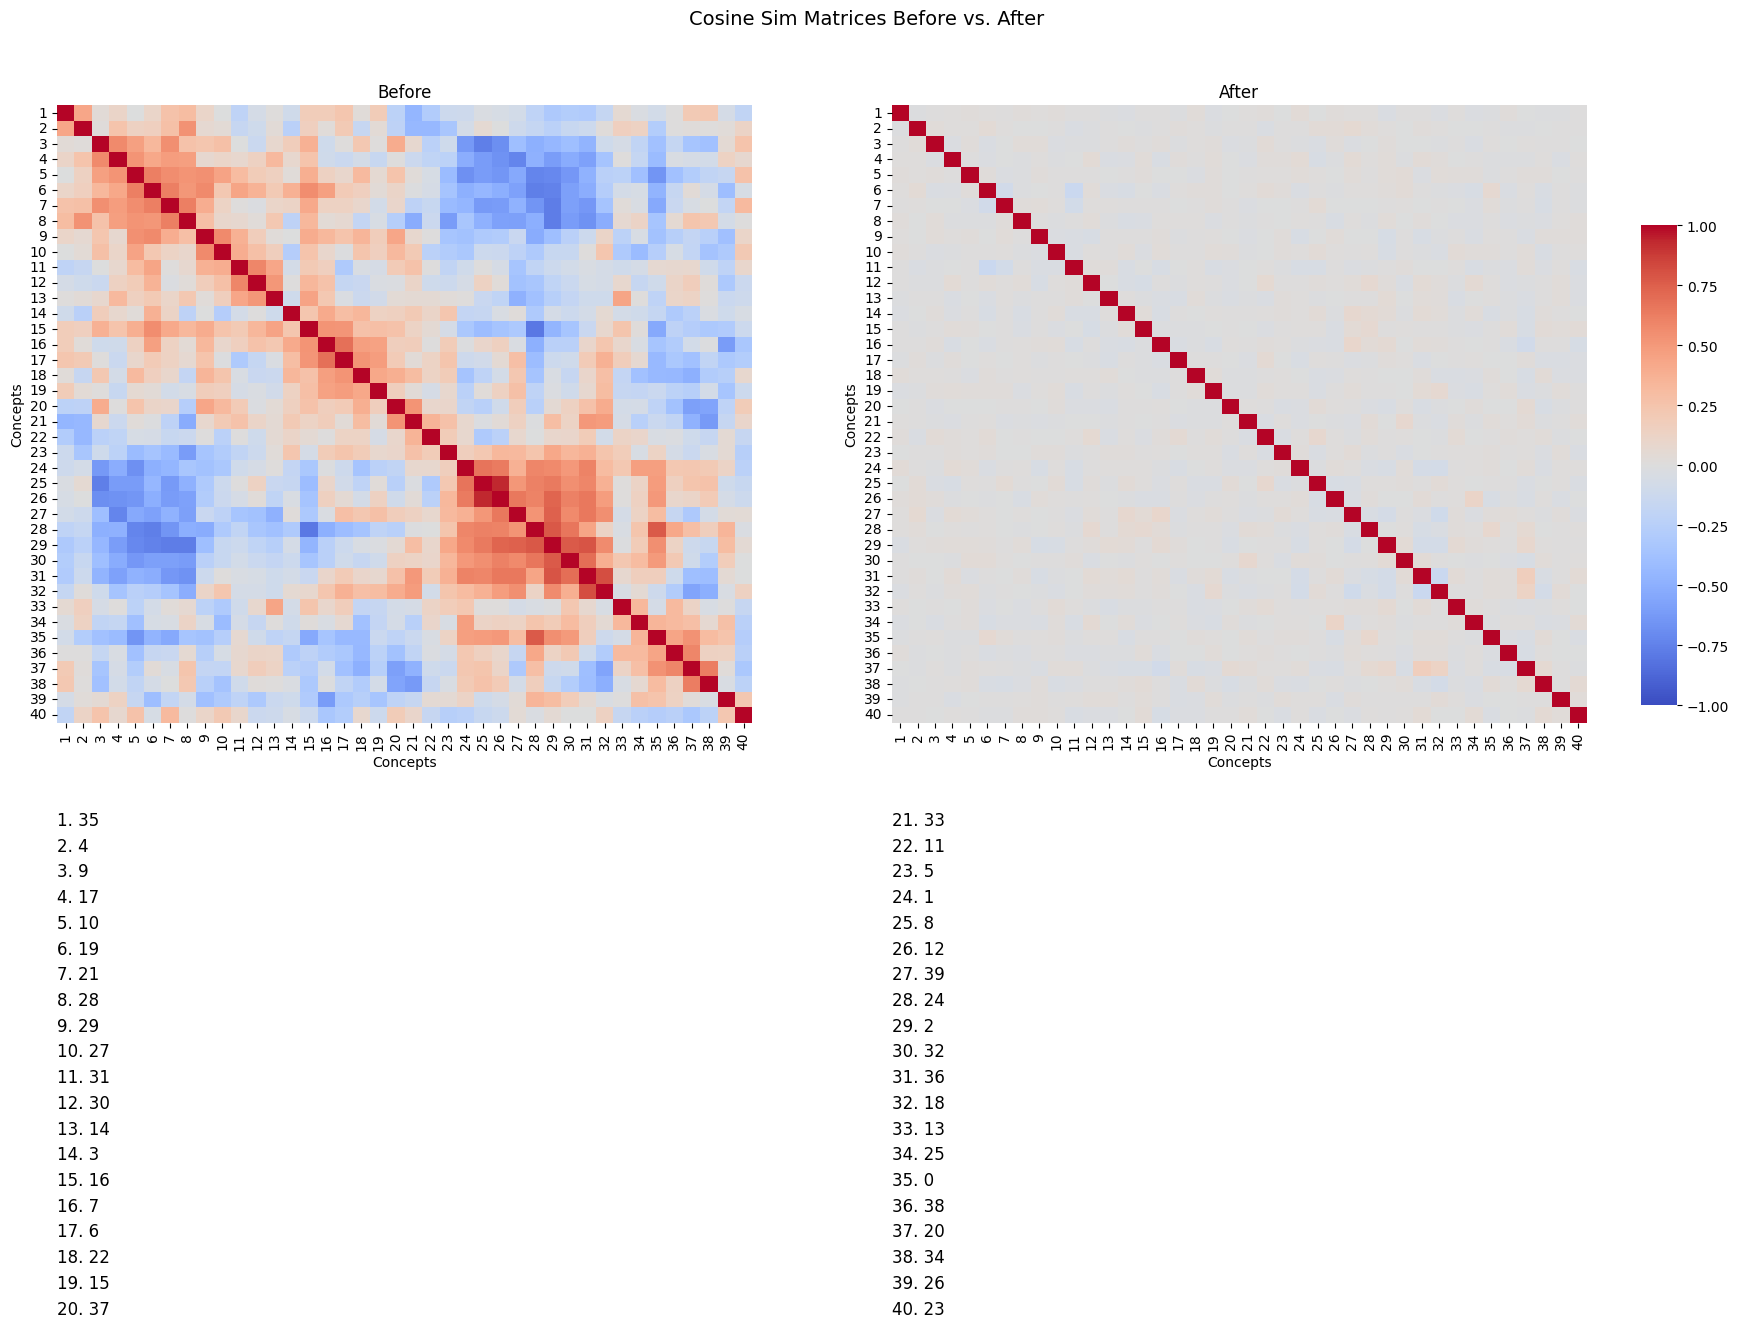

In [9]:
from utils.visualizations import visualize_before_after_sim_matrices

cos_sim_pattern = multi_cavs_baseline @ multi_cavs_baseline.T
cos_sim_multi = multi_cavs_orth @ multi_cavs_orth.T
cnames = [str(i) for i in range(40)]

fig = visualize_before_after_sim_matrices(cos_sim_pattern, cos_sim_multi, labels=cnames)
fig.savefig(out_dir / "celeba_cav_sim_matrices2.pdf", dpi=300, bbox_inches='tight', format='pdf')
fig

In [6]:
dataset = "elements"
model = "simplenet"
layer = "features.18"
alpha1 = "100"
alpha2 = "100"
lr1 = "1e-05"
lr2 = "1e-05"

pattern_cavs_baseline = get_baseline_cavs(model, layer, dataset, "pattern_cav")
multi_cavs_baseline = get_baseline_cavs(model, layer, dataset, "multi_cav")
pattern_cavs_orth = get_orth_cavs(model, layer, dataset, "pattern_cav", alpha1, lr1)
multi_cavs_orth = get_orth_cavs(model, layer, dataset, "multi_cav", alpha2, lr2)

# print(torch.linalg.norm(pattern_cavs_baseline, dim=1), torch.linalg.norm(multi_cavs_baseline, dim=1))
# print(torch.linalg.norm(pattern_cavs_orth, dim=1), torch.linalg.norm(multi_cavs_orth, dim=1))

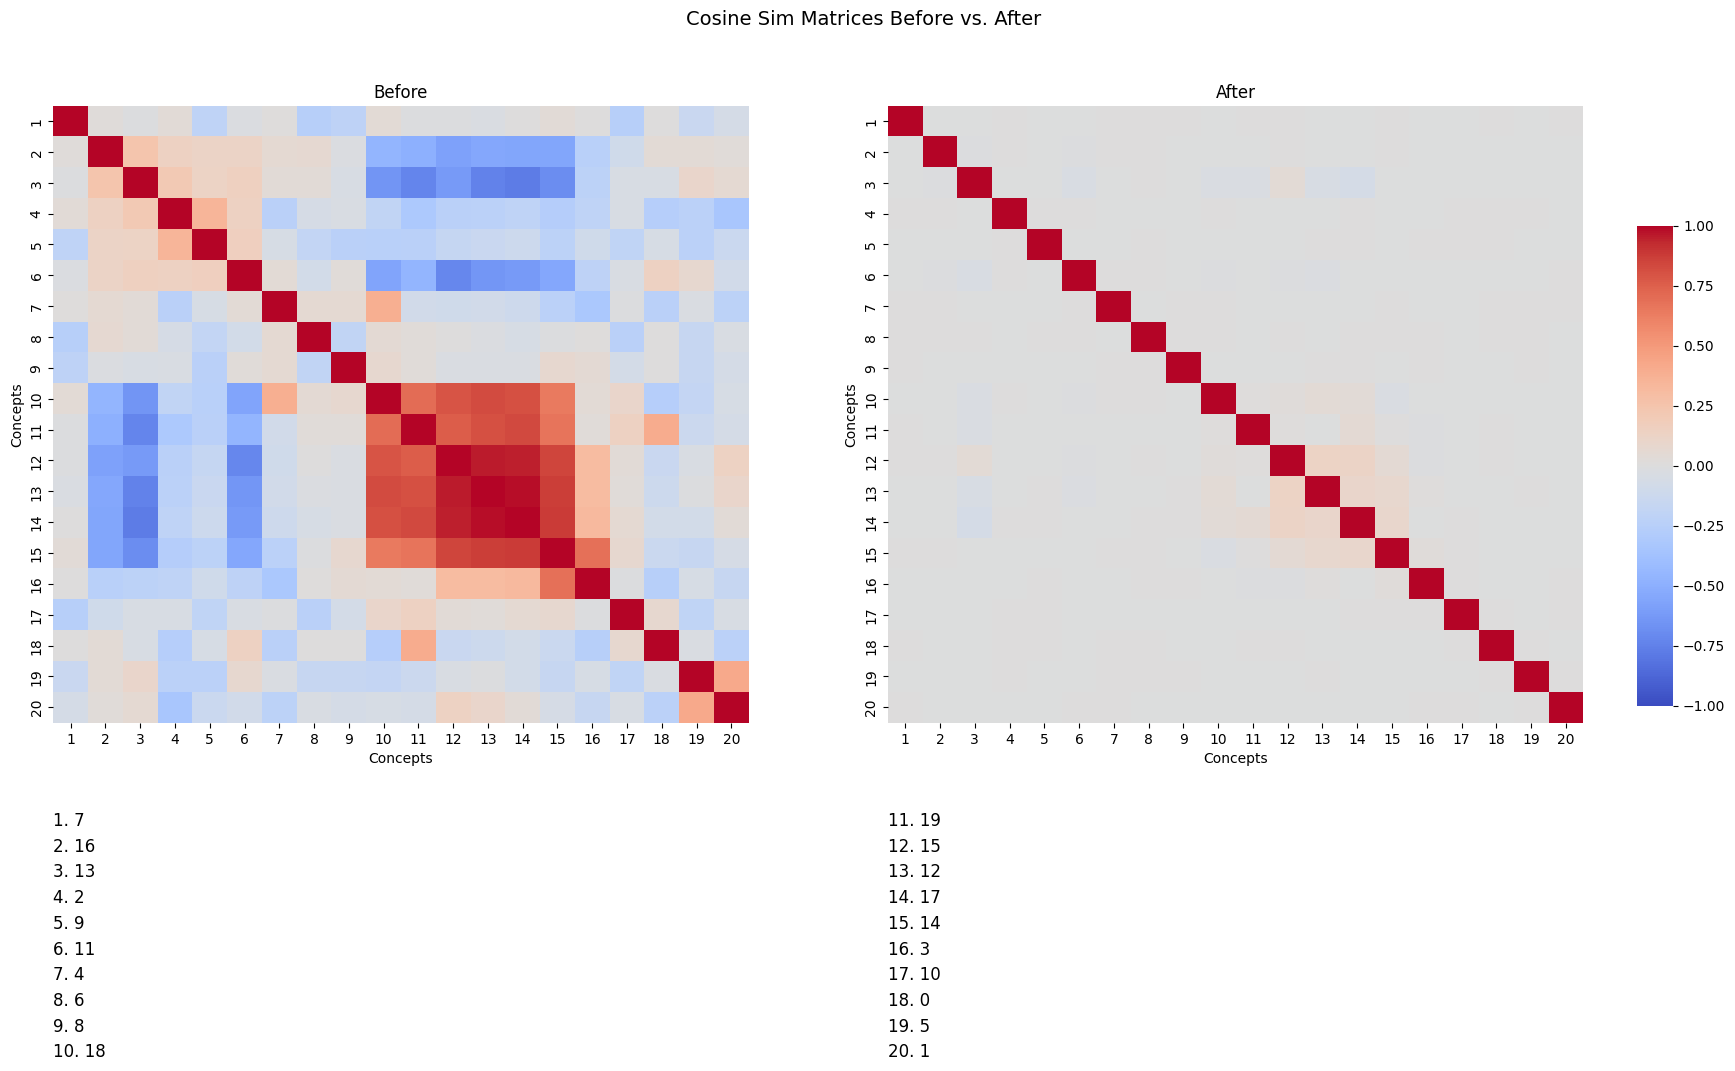

In [7]:
from utils.visualizations import visualize_before_after_sim_matrices

cos_sim_before = pattern_cavs_baseline @ pattern_cavs_baseline.T
cos_sim_after = pattern_cavs_orth @ pattern_cavs_orth.T
cnames = [str(i) for i in range(20)]

fig = visualize_before_after_sim_matrices(cos_sim_before, cos_sim_after, labels=cnames)
fig.savefig(out_dir / "elements_cav_sim_matrices_pattern.pdf", dpi=300, bbox_inches='tight', format='pdf')
fig

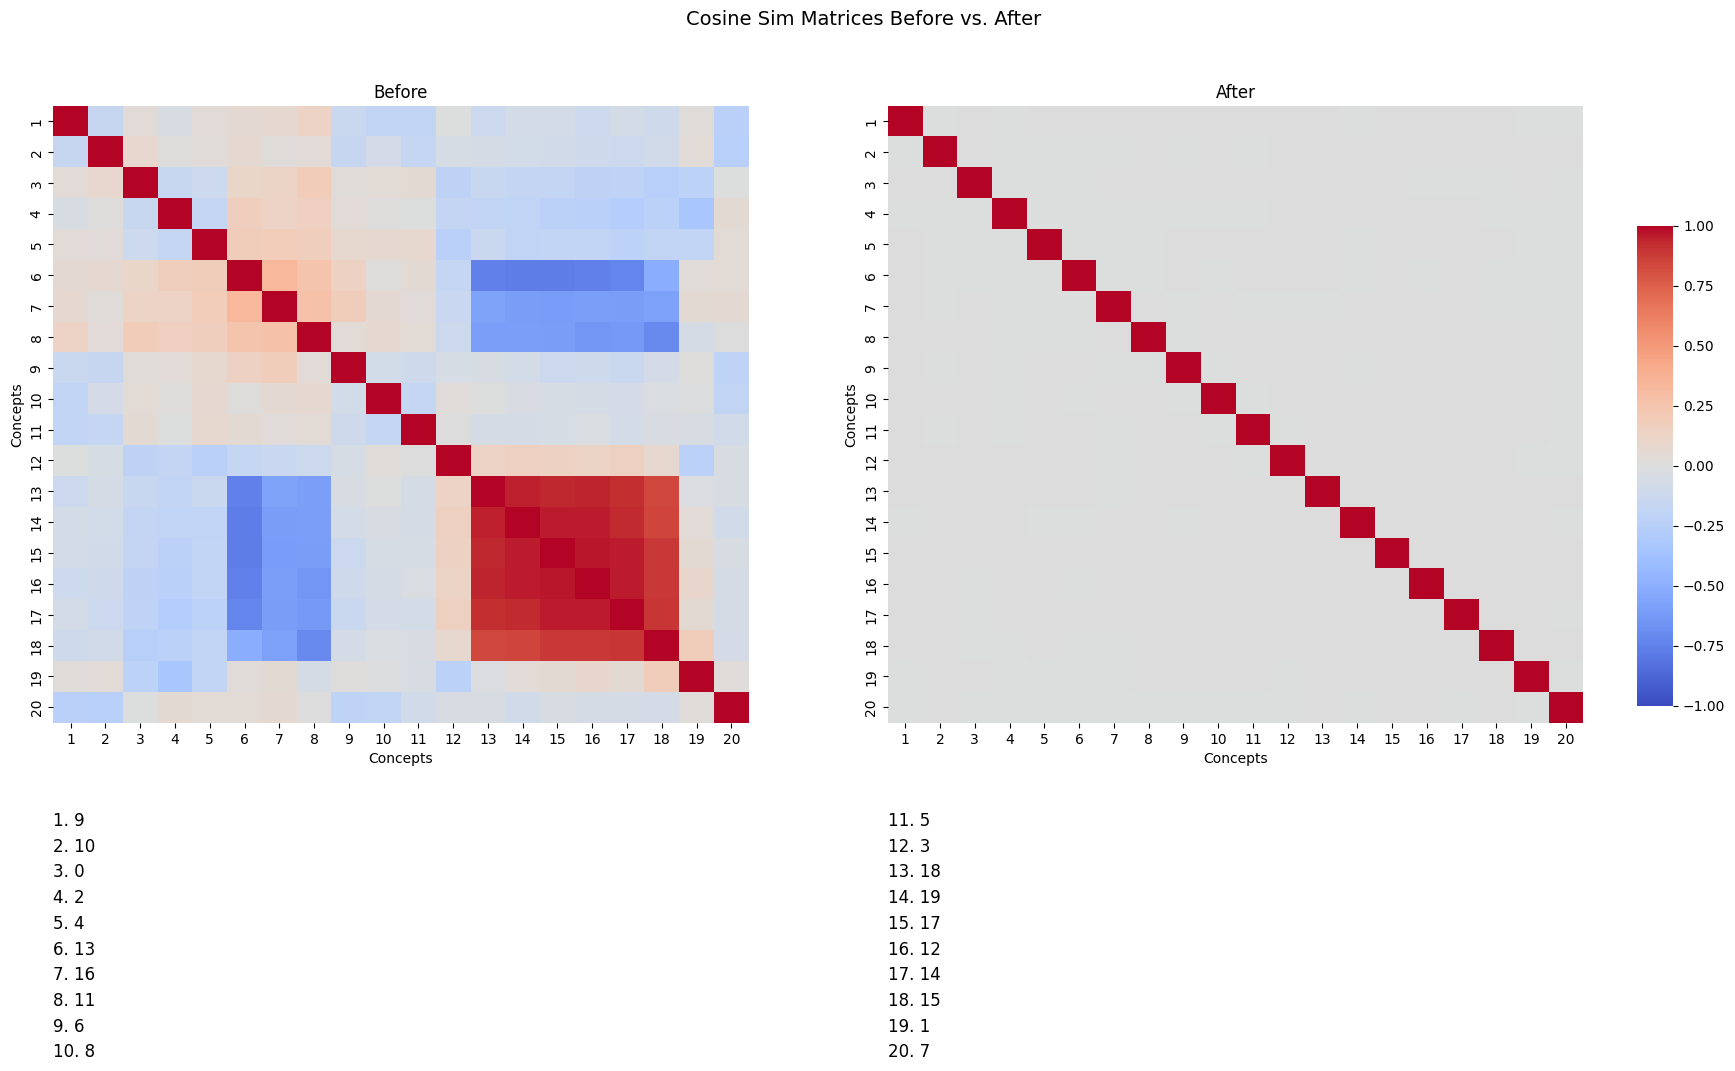

In [6]:
from utils.visualizations import visualize_before_after_sim_matrices

cos_sim_pattern = multi_cavs_baseline @ multi_cavs_baseline.T
cos_sim_multi = multi_cavs_orth @ multi_cavs_orth.T
cnames = [str(i) for i in range(20)]

fig = visualize_before_after_sim_matrices(cos_sim_pattern, cos_sim_multi, labels=cnames)
fig.savefig(out_dir / "elements_cav_sim_matrices_multi.pdf", dpi=300, bbox_inches='tight', format='pdf')
fig

## Per-Concept AUROC-Orth Delta

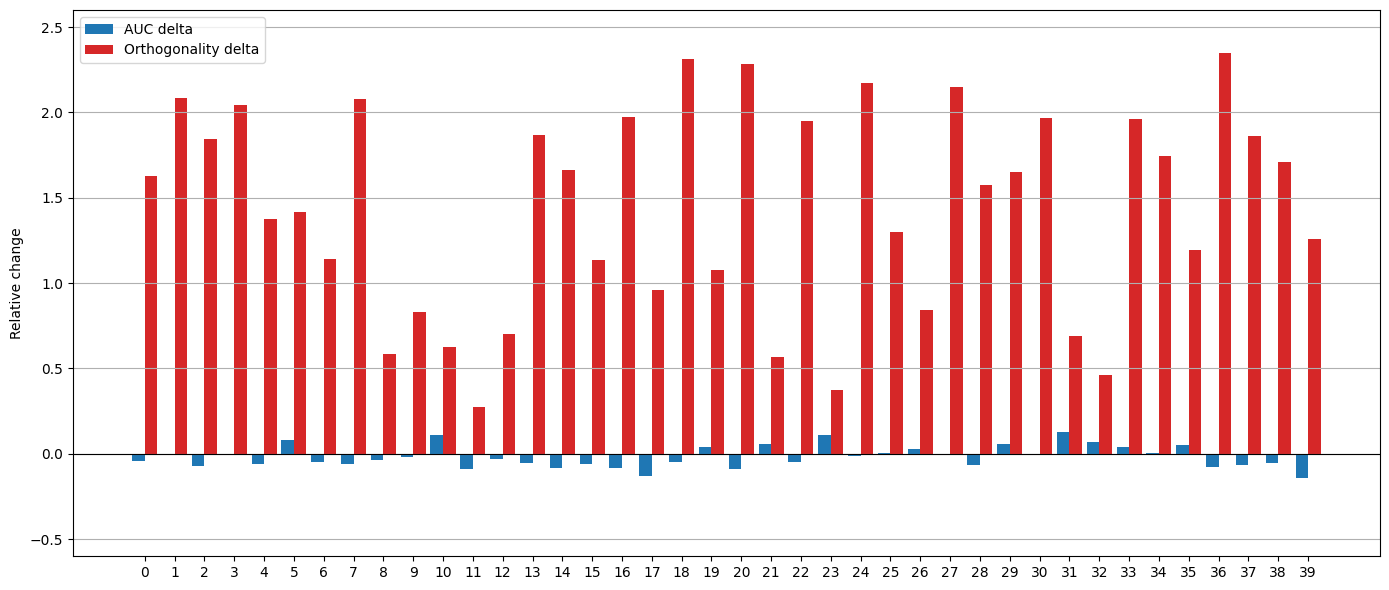

In [7]:
from utils.metrics import compute_auc_performance, get_uniqueness

def plot_per_concept_deltas(
    dataset_name: str,
    model_name: str,
    layer: str,
    cav_type: str,
    alpha: str,
    lr: str,
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    concept_names: list[str] | None = None,
    relative: bool = False,
    ylims: tuple[float, float] = (-2, 2),
    eps: float = 1e-12,
    out_path: Path | str | None = None,
):
    vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars["encs"]
    labels = vars["labels"].clamp(min=0)

    concept_names = [f"{i}" for i in range(labels.shape[1])]

    cavs_baseline = get_baseline_cavs(model_name, layer, dataset_name, cav_type)
    cavs_orth = get_orth_cavs(model_name, layer, dataset_name, cav_type, alpha, lr)

    auc_before = compute_auc_performance(cavs_baseline, encs, labels)
    auc_after = compute_auc_performance(cavs_orth, encs, labels)
    orth_before = get_uniqueness(cavs_baseline)
    orth_after = get_uniqueness(cavs_orth)

    delta_auc = np.array(auc_after) - np.array(auc_before)
    delta_orth = np.array(orth_after) - np.array(orth_before)

    if relative:
        delta_auc = delta_auc / (np.abs(auc_before) + eps)
        delta_orth = delta_orth / (np.abs(orth_before) + eps)
    x = np.arange(len(concept_names))
    width = 0.42

    fig, ax = plt.subplots(figsize=(max(10, 0.35 * len(concept_names)), 6))
    ax.bar(x - width / 2, delta_auc, width=width, color="tab:blue", label="AUC delta")
    ax.bar(x + width / 2, delta_orth, width=width, color="tab:red", label="Orthogonality delta")

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(concept_names)
    ax.set_ylabel("Relative change" if relative else "Absolute change")
    # ax.set_title("Pattern → Multi: Per‑Concept Metric Change")
    ax.grid(axis="y")
    ax.legend()

    ax.set_ylim(ylims[0] - 0.1 , ylims[1] + 0.1)

    fig.tight_layout()

    if out_path is not None:
        out_path = Path(out_path)
        fig.savefig(out_path, bbox_inches="tight", format="pdf")

    return {
        "delta_auc": delta_auc,
        "delta_orth": delta_orth,
        "concept_names": concept_names,
    }

ylims = (-0.5, 2.5)
plot_per_concept_deltas("celeba", 
                        "vgg16", 
                        "features.28", 
                        "pattern_cav", 
                        "10",
                        "1e-05",
                        relative=True,  
                        ylims=ylims, 
                        out_path=out_dir / "deltas_celeba_pattern.pdf");

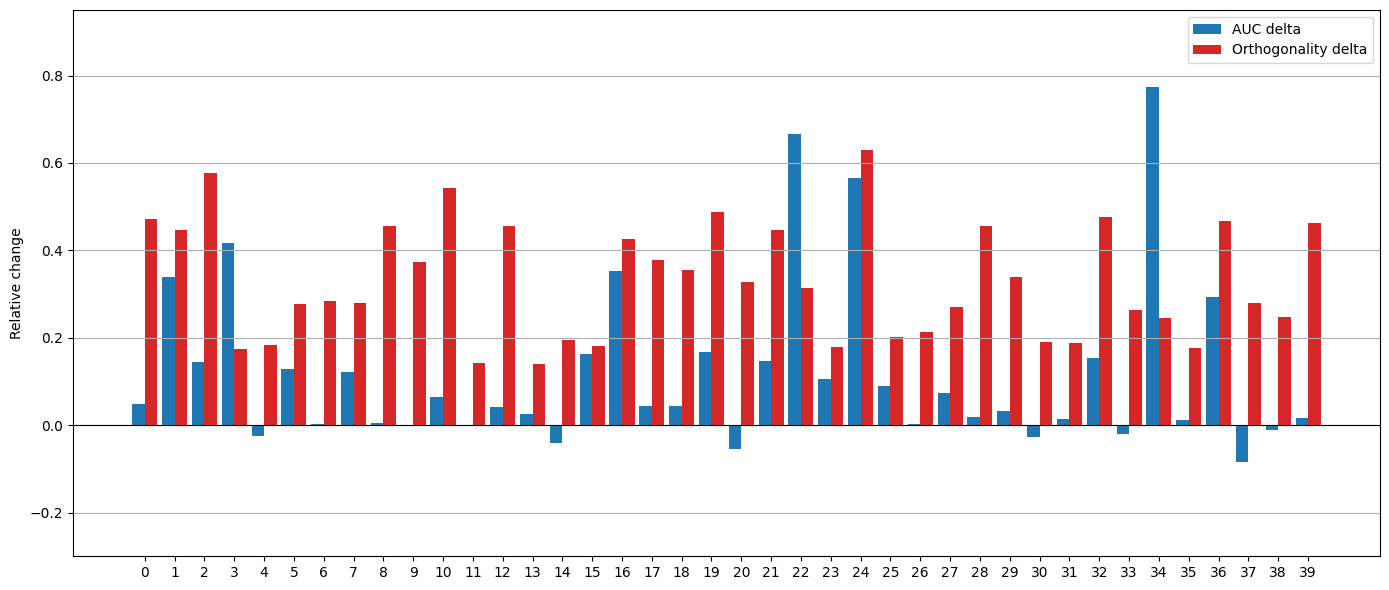

In [27]:
ylims = (-0.2, 0.85)
plot_per_concept_deltas("celeba", 
                        "vgg16", 
                        "features.28", 
                        "multi_cav", 
                        "10",
                        "1e-05",
                        relative=True,  
                        ylims=ylims, 
                        out_path=out_dir / "deltas_celeba_multi.pdf");

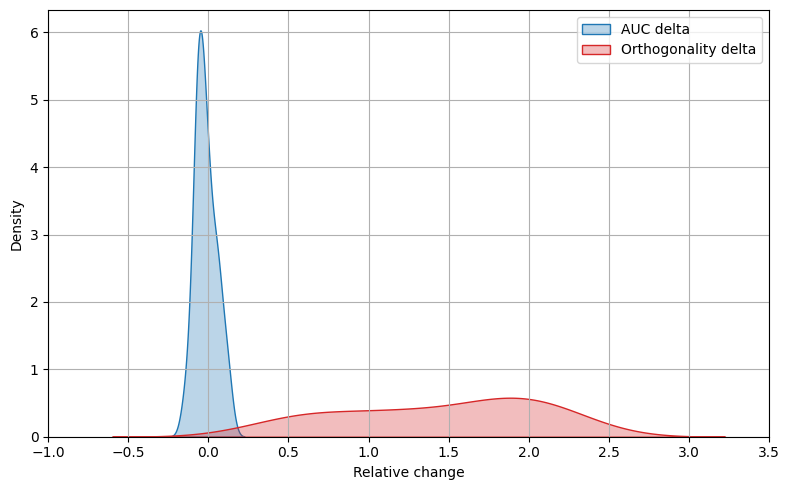

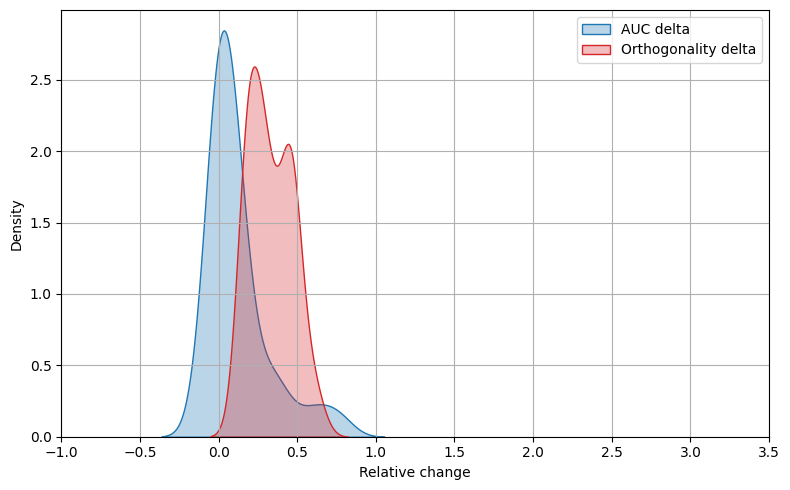

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils.metrics import compute_auc_performance, get_uniqueness

def plot_per_concept_deltas(
    dataset_name: str,
    model_name: str,
    layer: str,
    cav_type: str,
    alpha: str,
    lr: str,
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    concept_names: list[str] | None = None,
    relative: bool = False,
    xlims: tuple[float, float] = (-2, 2),
    eps: float = 1e-12,
    out_path: Path | str | None = None,
):
    vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars["encs"]
    labels = vars["labels"].clamp(min=0)

    concept_names = [f"{i}" for i in range(labels.shape[1])]

    cavs_baseline = get_baseline_cavs(model_name, layer, dataset_name, cav_type)
    cavs_orth = get_orth_cavs(model_name, layer, dataset_name, cav_type, alpha, lr)

    auc_before = compute_auc_performance(cavs_baseline, encs, labels)
    auc_after = compute_auc_performance(cavs_orth, encs, labels)
    orth_before = get_uniqueness(cavs_baseline)
    orth_after = get_uniqueness(cavs_orth)

    delta_auc = np.array(auc_after) - np.array(auc_before)
    delta_orth = np.array(orth_after) - np.array(orth_before)

    if relative:
        delta_auc = delta_auc / (np.abs(auc_before) + eps)
        delta_orth = delta_orth / (np.abs(orth_before) + eps)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.kdeplot(delta_auc, ax=ax, color="tab:blue", label="AUC delta", fill=True, alpha=0.3)
    sns.kdeplot(delta_orth, ax=ax, color="tab:red", label="Orthogonality delta", fill=True, alpha=0.3)

    # ax.axvline(0, color="black", linewidth=0.8)
    ax.set_xlabel("Relative change" if relative else "Absolute change")
    ax.set_ylabel("Density")
    ax.set_xlim(xlims[0], xlims[1])
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    if out_path is not None:
        out_path = Path(out_path)
        fig.savefig(out_path, bbox_inches="tight", format="pdf")

    return {
        "delta_auc": delta_auc,
        "delta_orth": delta_orth,
        "concept_names": concept_names,
    }

plot_per_concept_deltas("celeba", 
                        "vgg16", 
                        "features.28", 
                        "pattern_cav", 
                        "10",
                        "1e-05",
                        relative=True,  
                        xlims=(-1, 3.5),
                        out_path=out_dir / "deltas_celeba_pattern.pdf");

plot_per_concept_deltas("celeba", 
                        "vgg16", 
                        "features.28", 
                        "multi_cav", 
                        "10",
                        "1e-05",
                        relative=True,  
                        xlims=(-1, 3.5),
                        out_path=out_dir / "deltas_celeba_multi.pdf");

## Over Layers

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils.cav import compute_cavs
from utils.metrics import compute_auc_performance, get_uniqueness


def plot_avg_metric_deltas_over_layers(
    dataset_name: str,
    model_name: str,
    layers: list[str],
    cav_type: str,
    alpha: str,
    lr: str,
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    relative: bool = False,
    y_lims: tuple[float, float] | None = None,
    eps: float = 1e-12,
    out_path: Path | str | None = None,
):
    """
    Bar plot of average AUROC/orthogonality change per layer (pattern -> multi).
    If relative=True, uses (multi - pattern) / (abs(pattern) + eps).
    """
    variables_root = Path(variables_root)
    avg_auc_before = []
    avg_auc_after = []
    avg_orth_before = []
    avg_orth_after = []

    for layer in layers:
        vars_path = variables_root / dataset_name / model_name / f"{layer}.pth"
        vars = torch.load(vars_path, map_location="cpu", weights_only=True)
        encs = vars["encs"]
        labels = vars["labels"].clamp(min=0)

        cavs_before = get_baseline_cavs(model_name, layer, dataset_name, cav_type)
        cavs_after = get_orth_cavs(model_name, layer, dataset_name, cav_type, alpha, lr)

        auc_before = compute_auc_performance(cavs_before, encs, labels)
        auc_after = compute_auc_performance(cavs_after, encs, labels)
        orth_before = get_uniqueness(cavs_before)
        orth_after = get_uniqueness(cavs_after)

        avg_auc_before.append(float(np.nanmean(auc_before)))
        avg_auc_after.append(float(np.nanmean(auc_after)))
        avg_orth_before.append(float(np.nanmean(orth_before)))
        avg_orth_after.append(float(np.nanmean(orth_after)))

    delta_auc = np.array(avg_auc_after) - np.array(avg_auc_before)
    delta_orth = np.array(avg_orth_after) - np.array(avg_orth_before)

    if relative:
        delta_auc = delta_auc / (np.abs(avg_auc_before) + eps)
        delta_orth = delta_orth / (np.abs(avg_orth_before) + eps)

    x = np.arange(len(layers))
    width = 0.42

    fig, ax = plt.subplots(figsize=(max(10, 0.5 * len(layers)), 6))
    ax.bar(x - width / 2, delta_auc, width=width, color="tab:blue", label="Avg AUC delta")
    ax.bar(x + width / 2, delta_orth, width=width, color="tab:red", label="Avg Orth delta")

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i}" for i in range(len(layers))])
    ax.set_ylabel("Relative change" if relative else "Absolute change")
    ax.grid(axis="y")
    ax.set_ylim(y_lims[0] - 0.1 , y_lims[1] + 0.1) if y_lims is not None else None

    ax.legend()
    fig.tight_layout()

    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight", format="pdf")

    return {
        "avg_auc_before": np.array(avg_auc_before),
        "avg_auc_after": np.array(avg_auc_after),
        "avg_orth_before": np.array(avg_orth_before),
        "avg_orth_after": np.array(avg_orth_after),
        "delta_auc": delta_auc,
        "delta_orth": delta_orth,
        "layers": layers,
    }



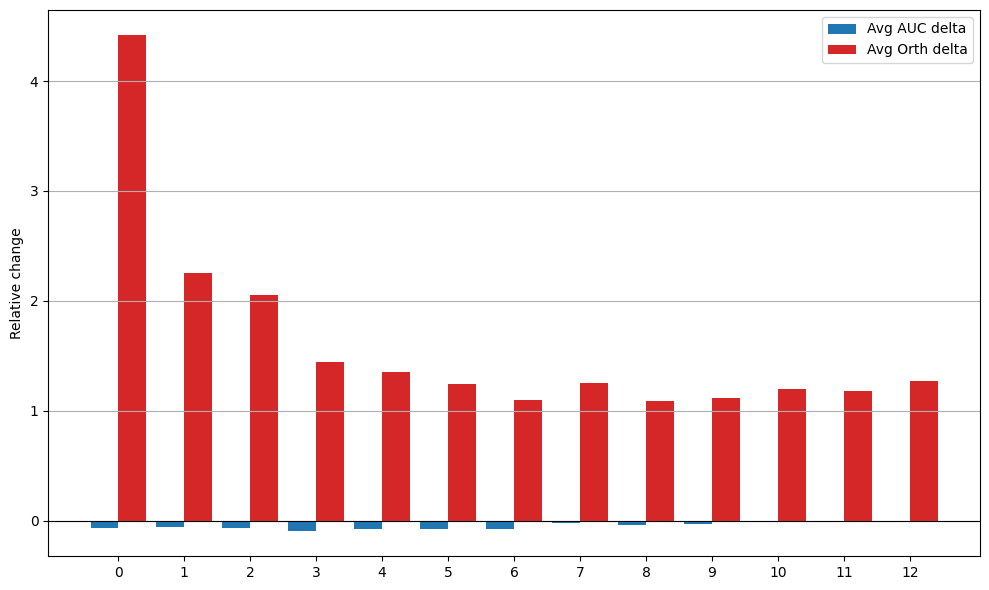

In [6]:
layers = ["features.0", "features.2", "features.5", "features.7", "features.10", "features.12", "features.14", "features.17", "features.19", "features.21", "features.24", "features.26", "features.28"]
plot_avg_metric_deltas_over_layers(
    "celeba", 
    "vgg16", 
    layers, 
    "pattern_cav",
    "10",
    "0.0001",
    relative=True, 
    out_path=out_dir / "deltas_over_layers_pattern.pdf");

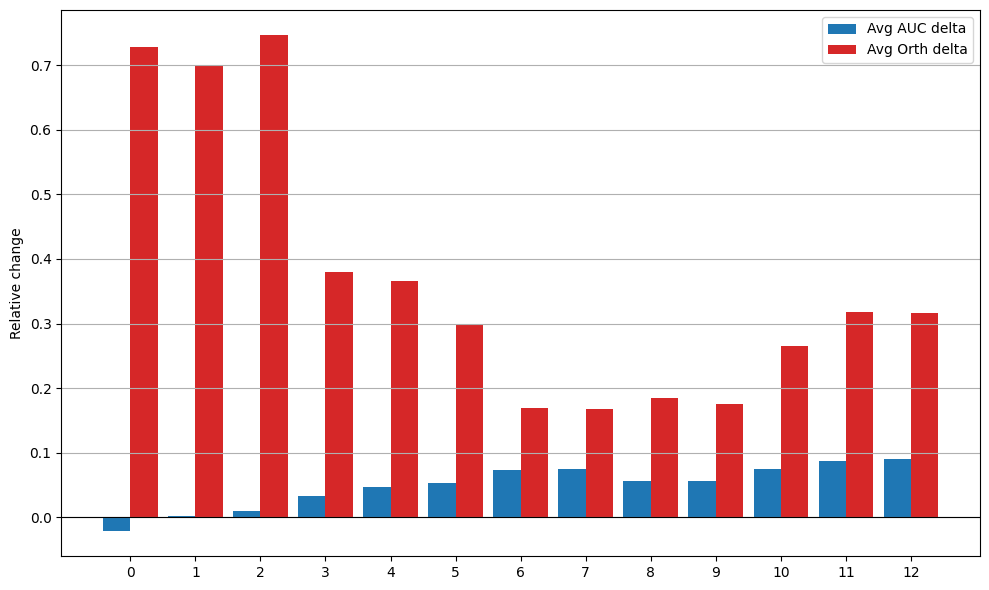

In [7]:
layers = ["features.0", "features.2", "features.5", "features.7", "features.10", "features.12", "features.14", "features.17", "features.19", "features.21", "features.24", "features.26", "features.28"]
plot_avg_metric_deltas_over_layers(
    "celeba", 
    "vgg16", 
    layers, 
    "multi_cav",
    "10",
    "0.0001",
    relative=True, 
    out_path=out_dir / "deltas_over_layers_multi.pdf");

## Weighting Parameter

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from utils.metrics import compute_auc_performance, get_uniqueness


def plot_auroc_orthogonality_over_alphas(
    dataset_name: str,
    model_name: str,
    layer: str,
    cav_type: str,
    alphas: list[float],
    lr: str,
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    y_lims: tuple[float, float] | None = None,
    out_path: Path | str | None = None,
):
    variables_root = Path(variables_root)
    vars_path = variables_root / dataset_name / model_name / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars["encs"]
    labels = vars["labels"].clamp(min=0)

    aucs = []
    orths = []
    for alpha in alphas:
        cavs_orth = get_orth_cavs(model_name, layer, dataset_name, cav_type, str(alpha), lr, opt=False)
        auc = compute_auc_performance(cavs_orth, encs, labels)
        orth = get_uniqueness(cavs_orth)

        aucs.append(float(np.nanmean(auc)))
        orths.append(float(np.nanmean(orth)))

    aucs = np.array(aucs)
    orths = np.array(orths)
    x = np.arange(len(alphas))

    fig, ax = plt.subplots(figsize=(max(10, 0.5 * len(alphas)), 6))
    ax.plot(x, aucs, color="tab:blue", marker="o", label="Avg AUC")
    ax.plot(x, orths, color="tab:red", marker="o", label="Avg Orthogonality")

    ax.set_xticks(x)
    ax.set_xticklabels([f"{i:.4f}" for i in alphas])
    ax.set_ylabel("Value")
    ax.grid(axis="y")
    if y_lims is not None:
        ax.set_ylim(y_lims[0] - 0.02, y_lims[1] + 0.02)

    ax.legend()
    fig.tight_layout()

    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight", format="pdf")

    return {
        "aucs": aucs,
        "orths": orths,
        "alphas": alphas,
    }


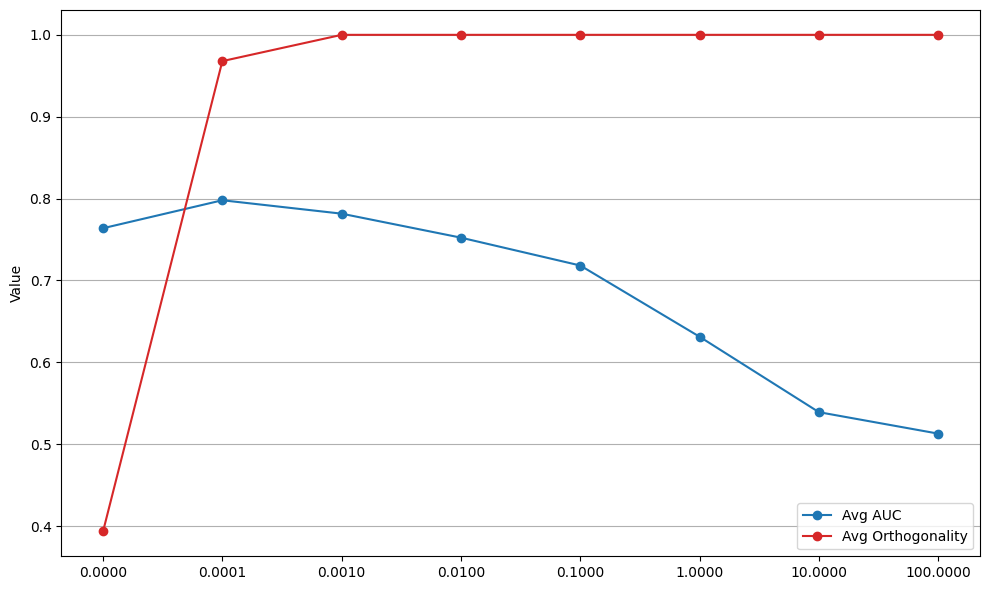

In [20]:
plot_auroc_orthogonality_over_alphas(
    "celeba",
    "vgg16",
    "features.28",
    "pattern_cav",
    [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "0.0001",
    out_path=out_dir / "auroc_orthogonality_over_alphas_pattern.pdf"
);  

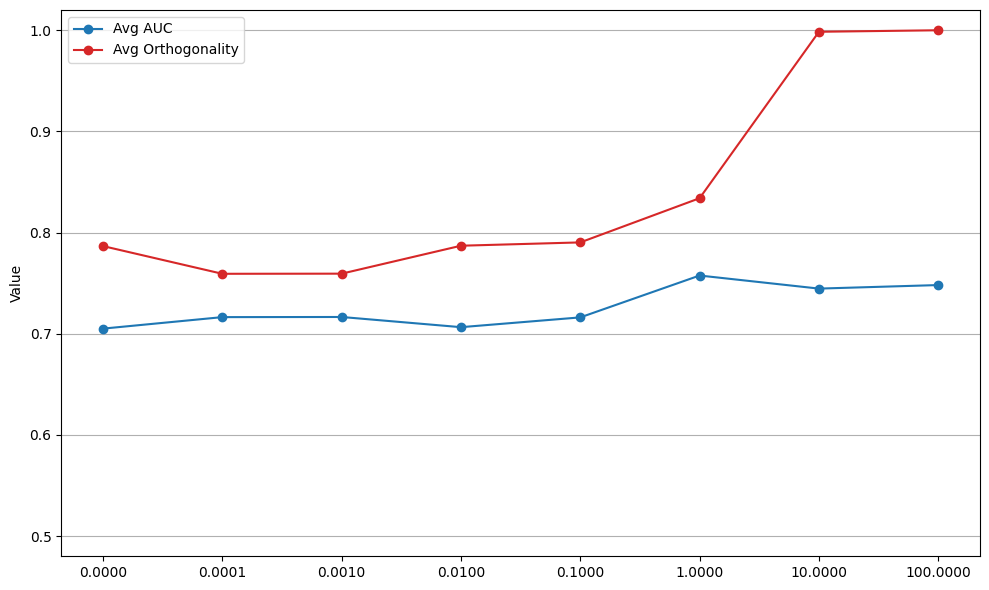

In [5]:
plot_auroc_orthogonality_over_alphas(
    "celeba",
    "vgg16",
    "features.28",
    "multi_cav",
    [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    "0.0001",
    y_lims=(0.5, 1.0),
    out_path=out_dir / "auroc_orthogonality_over_alphas_multi.pdf"
);  

## Concept Localization

In [11]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils.cav import compute_cavs
from utils.visualizations import visualize_heatmaps, visualize_heatmap_pair
from experiments.utils.localization import get_localization
from models import get_fn_model_loader, get_canonizer


def localize_baseline_orth_cavs(
    image_id: int,
    concept_id: int,
    dataset,
    baseline_cavs1: torch.Tensor,
    orth_cavs1: torch.Tensor,
    baseline_cavs2: torch.Tensor,
    orth_cavs2: torch.Tensor,
    *,
    dataset_name: str = "celeba",
    model_name: str = "vgg16",
    layer: str = "features.28",
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    ckpt_path: Path | str | None = None,
    n_class: int | None = 2,
    cav_mode: str = "max",
    device: str = "cpu",
    out_path: Path | str | None = None,
    dps: bool = False,
):
    # Load encs/labels if not provided (assumes dataset ordering matches cached encs)
    vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
    vars_data = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars_data["encs"]
    labels = vars_data["labels"].clamp(min=0)

    # Load model if not provided
    if ckpt_path is None:
        ckpt_path = Path("/media/erogullari/checkpoints") / f"checkpoint_{model_name}_{dataset_name}.pth"

    model = get_fn_model_loader(model_name)(
        ckpt_path=ckpt_path,
        pretrained=True,
        n_class=n_class,
    ).to(device).eval()

    canonizers = get_canonizer(model_name)

    # Get single sample
    sample = dataset[image_id][0].unsqueeze(0)

    # Localize (same logic as localization.py)
    hm_pattern_baseline = get_localization(
        baseline_cavs1[concept_id].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_pattern_orth = get_localization(
        orth_cavs1[concept_id].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_multi_baseline = get_localization(
        baseline_cavs2[concept_id].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_multi_orth = get_localization(
        orth_cavs2[concept_id].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    heatmaps_pattern = torch.cat([hm_pattern_baseline, hm_pattern_orth], dim=1)[0]
    heatmaps_multi = torch.cat([hm_multi_baseline, hm_multi_orth], dim=1)[0]
    pair_heatmaps = torch.stack([heatmaps_pattern, heatmaps_multi])     # (2, 2, H, W)

    # Dot products (optional annotation)
    latent = encs[image_id].to(baseline_cavs1)
    dp_baseline_pattern = torch.dot(latent, baseline_cavs1[concept_id].to(latent)).item()
    dp_orth_pattern = torch.dot(latent, orth_cavs1[concept_id].to(latent)).item()
    dp_baseline_multi = torch.dot(latent, baseline_cavs2[concept_id].to(latent)).item()
    dp_orth_multi = torch.dot(latent, orth_cavs2[concept_id].to(latent)).item()
    dot_products = torch.tensor([
        [dp_baseline_pattern, dp_orth_pattern],
        [dp_baseline_multi, dp_orth_multi],
    ]) if dps else None

    concept_names = dataset.get_concept_names()
    concept_name = concept_names[concept_id] if concept_names else f"concept_{concept_id}"

    titles = ["Original Image", "Baseline CAV", "Orthogonal CAV"]
    fig = visualize_heatmap_pair(
        sample[0].detach().cpu(),
        pair_heatmaps,
        conormalize=True,
        titles=titles,
        row_titles=["Pattern CAV", "Multi CAV"],
        dot_products=dot_products,
        display=out_path is None,
    )

    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight", format="pdf")
    return fig

save_dir = out_dir / "localizations" 
save_dir.mkdir(parents=True, exist_ok=True)

In [5]:
from datasets.celeba.celeba import CelebADataset
from hydra.utils import instantiate
from omegaconf import OmegaConf

cfg = OmegaConf.load("/home/erogullari/Workspace/cav-disentanglement/configs/dataset/celeba.yaml")
dataset = instantiate(cfg)
len(dataset)

202599

In [6]:
concept_names = dataset.get_concept_names()
for i in range(len(concept_names)):
    print(f"{i}: {concept_names[i]}")

0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


In [7]:
concept_idx = 4
print(f"Selected concept: {concept_names[concept_idx]}")

indices = np.where(dataset.get_labels()[:, concept_idx] == 1)[0]
print(f"Number of samples with concept: {len(indices)}")

Selected concept: Bald
Number of samples with concept: 4547


In [12]:
concept_idxs = [4, 8, 9, 16, 35, 38]
concept_idxs = [9, 16]
alpha1 = "0.001"
alpha2 = "10"
lr = "0.0001"

pattern_baseline = get_baseline_cavs("vgg16", "features.28", "celeba", "pattern_cav")
pattern_orth = get_orth_cavs("vgg16", "features.28", "celeba", "pattern_cav", alpha1, lr, opt=True)
multi_baseline = get_baseline_cavs("vgg16", "features.28", "celeba", "multi_cav")
multi_orth = get_orth_cavs("vgg16", "features.28", "celeba", "multi_cav", alpha2, lr, opt=True)

start = 0
for concept_idx in concept_idxs:
    print(f"Selected concept: {concept_names[concept_idx]}")
    indices = np.where(dataset.get_labels()[:, concept_idx] == 1)[0]
    print(f"Number of samples with concept: {len(indices)}")
    for pos in range(start, start + 20):
        alpha_save_dir = out_dir / "localizations" / f"pattern_{alpha1}_multi_{alpha2}"
        alpha_save_dir.mkdir(parents=True, exist_ok=True)
        path = alpha_save_dir / f"concept_{concept_names[concept_idx]}_img_{indices[pos]}.pdf"
        localize_baseline_orth_cavs(
            indices[pos],
            concept_idx,
            dataset,
            pattern_baseline,
            pattern_orth,
            multi_baseline,
            multi_orth,
            dataset_name="celeba",
            model_name="vgg16",
            layer="features.28",
            cav_mode="max",
            device="cpu",
            out_path=path,
            dps=False,
        );


Selected concept: Blond_Hair
Number of samples with concept: 29983
Selected concept: Goatee
Number of samples with concept: 12716


## Concept Co-Localization

In [3]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils.cav import compute_cavs
from utils.visualizations import visualize_heatmap_pair
from experiments.utils.localization import get_localization
from models import get_fn_model_loader, get_canonizer


def colocalize_pattern_multi_cavs(
    image_id: int,
    concept_id_1: int,
    concept_id_2: int,
    dataset,
    baseline_cavs: torch.Tensor,
    orth_cavs: torch.Tensor,
    *,
    dataset_name: str = "celeba",
    model_name: str = "vgg16",
    layer: str = "features.28",
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    ckpt_path: Path | str | None = None,
    n_class: int | None = None,
    dps: bool = False,
    cav_mode: str = "max",
    device: str = "cpu",
    encs: torch.Tensor | None = None,
    labels: torch.Tensor | None = None,
    out_path: Path | str | None = None,
):
    # Load encs/labels if not provided (assumes dataset ordering matches cached encs)
    if encs is None or labels is None:
        vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
        vars_data = torch.load(vars_path, map_location="cpu", weights_only=True)
        encs = vars_data["encs"]
        labels = vars_data["labels"].clamp(min=0)

    # Load model if not provided
    if ckpt_path is None:
        ckpt_path = Path("/media/erogullari/checkpoints") / f"checkpoint_{model_name}_{dataset_name}.pth"

    model = get_fn_model_loader(model_name)(
        ckpt_path=ckpt_path,
        pretrained=True,
        n_class=n_class,
    ).to(device).eval()

    canonizers = get_canonizer(model_name)

    # Get single sample
    sample = dataset[image_id][0].unsqueeze(0)

    # Heatmaps for baseline CAVs
    hm_pat_c1 = get_localization(
        baseline_cavs[concept_id_1].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_pat_c2 = get_localization(
        baseline_cavs[concept_id_2].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    # Heatmaps for orthogonal CAVs
    hm_mul_c1 = get_localization(
        orth_cavs[concept_id_1].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_mul_c2 = get_localization(
        orth_cavs[concept_id_2].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    heatmaps_baseline = torch.cat([hm_pat_c1, hm_pat_c2], dim=1)[0]
    heatmaps_orth = torch.cat([hm_mul_c1, hm_mul_c2], dim=1)[0]
    pair_heatmaps = torch.stack([heatmaps_baseline, heatmaps_orth])  # (2, 2, H, W)

    # Dot products (optional annotations)
    latent = encs[image_id].to(baseline_cavs)
    dp_baseline = torch.matmul(latent, baseline_cavs[[concept_id_1, concept_id_2]].to(latent).T)
    dp_orth = torch.matmul(latent, orth_cavs[[concept_id_1, concept_id_2]].to(latent).T)
    dot_products = torch.stack([dp_baseline, dp_orth], dim=0)

    concept_names = dataset.get_concept_names()
    name_1 = concept_names[concept_id_1] if concept_names else f"concept_{concept_id_1}"
    name_2 = concept_names[concept_id_2] if concept_names else f"concept_{concept_id_2}"

    fig = visualize_heatmap_pair(
        sample[0].detach().cpu(),
        pair_heatmaps.detach().cpu(),
        titles=["Original Image", name_1, name_2],
        row_titles=["Baseline CAV", "Orthogonal CAV"],
        dot_products=dot_products.detach().cpu() if dps else None,
        conormalize=True,  # conormalize all 4 heatmaps together
        display=out_path is None,
    )

    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight", format="pdf")
    return fig

save_dir = out_dir / "colocalizations"
save_dir.mkdir(parents=True, exist_ok=True)

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets.celeba.celeba import CelebADataset
from hydra.utils import instantiate
from omegaconf import OmegaConf

cfg = OmegaConf.load("/home/erogullari/Workspace/cav-disentanglement/configs/dataset/celeba.yaml")
dataset = instantiate(cfg)
len(dataset)

202599

In [5]:
concept_names = dataset.get_concept_names()
for i in range(len(concept_names)):
    print(f"{i}: {concept_names[i]}")

0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


In [19]:
save_dir = out_dir / "colocalizations"

# concept_pairs = [(9, 38), (9, 24), (8, 38), (4, 31), (9, 16), (9, 22), (22, 38)]
concept_pairs = [(9, 16)]

cav_type = "pattern_cav"
alpha = "0.01"
lr = "0.0001"
baseline_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", cav_type)
orth_cavs = get_orth_cavs("vgg16", "features.28", "celeba", cav_type, alpha, lr, opt=True)

start = 60
for concept_idx1, concept_idx2 in concept_pairs:
    print(f"Selected concepts: {concept_names[concept_idx1]} and {concept_names[concept_idx2]}")
    indices = np.where((dataset.get_labels()[:, concept_idx1] == 1) & (dataset.get_labels()[:, concept_idx2] == 1))[0]
    print(f"Number of samples with concept: {len(indices)}")
    end = min(start + 20, len(indices))
    for pos in range(start, end):
        cav_save_dir = save_dir / f"{cav_type}_{alpha}"
        cav_save_dir.mkdir(parents=True, exist_ok=True)
        path = cav_save_dir / f"concept_{concept_names[concept_idx1]}_{concept_names[concept_idx2]}_img_{indices[pos]}.pdf"
        colocalize_pattern_multi_cavs(
            image_id=indices[pos],
            concept_id_1=concept_idx1,
            concept_id_2=concept_idx2,
            dataset=dataset,
            baseline_cavs=baseline_cavs,
            orth_cavs=orth_cavs,
            dataset_name="celeba",
            model_name="vgg16",
            layer="features.28",
            cav_mode="max",
            device="cpu",
            n_class=2,
            out_path=path,
            dps=False
        )


Selected concepts: Blond_Hair and Goatee
Number of samples with concept: 93


In [18]:
cav_type = "multi_cav"
alpha = "10"
lr = "0.0001"
baseline_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", cav_type)
orth_cavs = get_orth_cavs("vgg16", "features.28", "celeba", cav_type, alpha, lr, opt=True)

for concept_idx1, concept_idx2 in concept_pairs:
    print(f"Selected concepts: {concept_names[concept_idx1]} and {concept_names[concept_idx2]}")
    indices = np.where((dataset.get_labels()[:, concept_idx1] == 1) & (dataset.get_labels()[:, concept_idx2] == 1))[0]
    print(f"Number of samples with concept: {len(indices)}")
    end = min(start + 20, len(indices))
    for pos in range(start, end):
        cav_save_dir = save_dir / f"{cav_type}_{alpha}"
        cav_save_dir.mkdir(parents=True, exist_ok=True)
        path = cav_save_dir / f"concept_{concept_names[concept_idx1]}_{concept_names[concept_idx2]}_img_{indices[pos]}.pdf"
        colocalize_pattern_multi_cavs(
            image_id=indices[pos],
            concept_id_1=concept_idx1,
            concept_id_2=concept_idx2,
            dataset=dataset,
            baseline_cavs=baseline_cavs,
            orth_cavs=orth_cavs,
            dataset_name="celeba",
            model_name="vgg16",
            layer="features.28",
            cav_mode="max",
            device="cpu",
            n_class=2,
            out_path=path,
            dps=False
        )


Selected concepts: Blond_Hair and Goatee
Number of samples with concept: 93


## Main Figure Heatmaps

In [9]:
from torch import nn
import torchvision.transforms as T
from typing import List
from crp.attribution import CondAttribution
from zennit.canonizers import Canonizer
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer, VGGCanonizer
from crp.image import imgify
from experiments.utils.activations import _get_features, extract_latents
from experiments.utils.localization import get_localization
from utils.visualizations import visualize_heatmaps, visualize_heatmap_pair



In [4]:
from datasets import get_celeba_dataset
from models import get_vgg16

result_dir = Path("/home/erogullari/Workspace/cav-disentanglement/results/cav_disentanglement/celeba/vgg16_features.28")
out_dir = Path("/home/erogullari/Workspace/cav-disentanglement/media/cav_disentanglement")
ckpt_path = Path("/media/erogullari/checkpoints/checkpoint_vgg16_celeba.pth")
data_path = Path("/home/erogullari/datasets/")

model = get_vgg16(ckpt_path, n_class=2).to("cpu")
dataset = get_celeba_dataset([data_path], normalize_data=True, image_size=128)

Number of samples with mustache and necktie:  1692
108


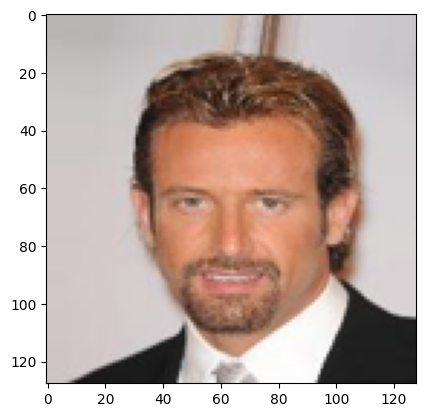

208


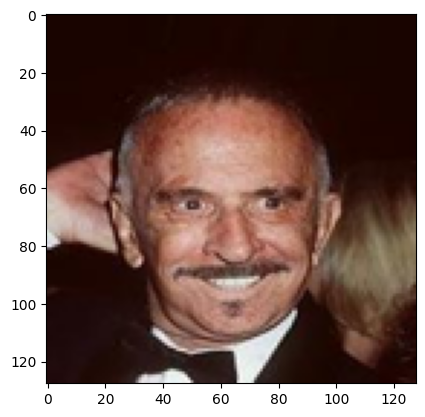

451


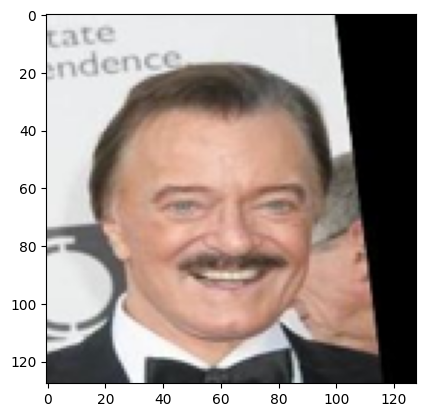

536


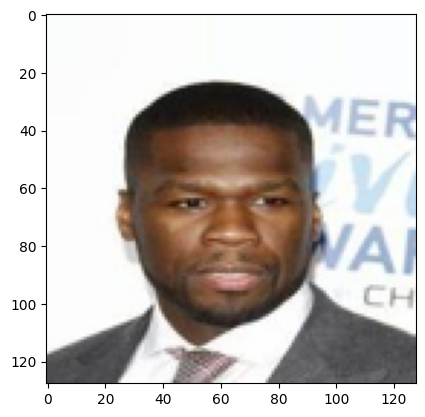

660


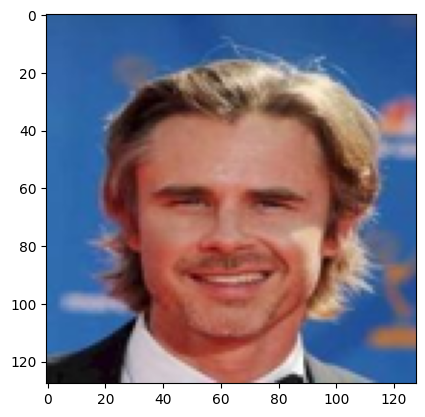

In [7]:
concept_names = dataset.get_concept_names()
mustache_idx = concept_names.index("Mustache")
necktie_idx = concept_names.index("Wearing_Necktie")

# First locate rows in dataset.attributes where mustache and necktie are present
targets = dataset.attributes.loc[
    (dataset.attributes["Mustache"] == 1) & (dataset.attributes["Wearing_Necktie"] == 1)
].index.tolist()
print("Number of samples with mustache and necktie: ", len(targets))
start = 0

for img_id in targets[start:start + 5]:
    print(img_id)
    x, y = dataset[img_id]
    img = dataset.reverse_normalization(x).permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.show()

In [ ]:
cav_type = "pattern_cav"
alpha = "0.1"
lr = "0.0001"

cav_path = result_dir / cav_type / f"alpha{alpha}_lr{lr}_opt" / "cavs.pt"
cavs_orth = torch.load(cav_path, map_location="cpu")
cavs_baseline = get_baseline_cavs("vgg16", "features.28", "celeba", cav_type)



(torch.Size([40, 512]), torch.Size([40, 512]))

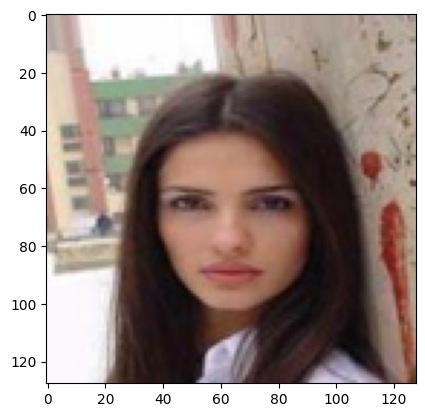

In [ ]:


def visualize_heatmaps(img: torch.Tensor, heatmaps: List[torch.Tensor], out_path: Path | None=None):
    """Visualize and save heatmaps for two concepts using both baseline and orthogonal CAVs. """



def localize_and_visualize(img: torch.Tensor, model: nn.Module, layer: str, cav_orth: torch.Tensor, cav_baseline: torch.Tensor, concept_idxs: List[int], device: str, out_dir: Path | None = None):
    canonizers: List[Canonizer] = [VGGCanonizer()]
    attribution = CondAttribution(model)
    cav1_orth = cav_orth[concept_idxs[0]]
    cav2_orth = cav_orth[concept_idxs[1]]
    cav1_baseline = cav_baseline[concept_idxs[0]]
    cav2_baseline = cav_baseline[concept_idxs[1]]

    x = img.unsqueeze(0)
    heatmap1_orth = get_localization(
        x, model, layer, cav1_orth, attribution, canonizers, cav_mode="max", device=device
    )
    heatmap2_orth = get_localization(
        x, model, layer, cav2_orth, attribution, canonizers, cav_mode="max", device=device  
    )
    heatmap_baseline1 = get_localization(
        x, model, layer, cav1_baseline, attribution, canonizers, cav_mode="max", device=device
    )
    heatmap_baseline2 = get_localization(
        x, model, layer, cav2_baseline, attribution, canonizers, cav_mode="max", device=device
    )

    visualize_heatmaps()
    